In [1]:
# Patching sklearn with scikit-learn-intelex for faster performance
import numpy as np
try:
    from sklearnex import patch_sklearn
    patch_sklearn()
except Exception as ex:
    print(f'Unable to use intelex version: {str(ex)}')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from tqdm.auto import tqdm

# Config libs
# Adapt font size of plots
plt.rcParams.update({'font.size': 18})
import plotly.io as pio
pio.renderers.default = "png" # Set to "svg" or "png" for static plots or "notebook_connected" for interactive plots

# Define experimental setup params

In [3]:
criteria = 'f1-score'
agg_metric = 'macro avg'

# Load data and create splits

In [4]:
df_mitocells = pd.read_csv('../data/all_cells_with_features.csv')
selected_features = ['nuclear_volume','nuclear_height','nuclear_surface_area',
                     'cell_volume','cell_height','cell_surface_area',
                    ]

In [5]:
for col in df_mitocells:
    if col.startswith('Shape') or col.startswith('Granularity'):
        selected_features.append(col)                                           
                                                                                 
selected_features = list(df_mitocells[selected_features].isna().any()[lambda x:~x].index)

In [6]:
Xy_train = df_mitocells[df_mitocells['split']=='train'][[*selected_features, 'cell_stage']].dropna(axis=0).to_numpy()
X_train = Xy_train[:,0:-1]
y_train = Xy_train[:,-1]
print(Xy_train.shape)

Xy_val = df_mitocells[df_mitocells['split']=='valid'][[*selected_features, 'cell_stage']].dropna(axis=0).to_numpy()
X_val = Xy_val[:,0:-1]
y_val = Xy_val[:,-1]
print(Xy_val.shape)

Xy_test = df_mitocells[df_mitocells['split']=='test'][[*selected_features, 'cell_stage']].dropna(axis=0).to_numpy()
X_test = Xy_test[:,0:-1]
y_test = Xy_test[:,-1]
print(Xy_test.shape)

(7266, 968)
(2076, 968)
(1039, 968)


# Random Forest Baseline

In [7]:
max_depth_opts = [2, 4, 8, 16]
n_estimators_opts = [128, 256, 512, 1024]
grid = []
models = {}
for max_depth in tqdm(max_depth_opts):
    for n_estimators in tqdm(n_estimators_opts, leave=False):
        clf = RandomForestClassifier(max_depth=max_depth,
                                     n_estimators=n_estimators,
                                     random_state=0, class_weight='balanced')
        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_train)
        scores = classification_report(y_train, y_pred, output_dict=True)[agg_metric]
        scores['max_depth'] = max_depth
        scores['n_estimators'] = n_estimators
        scores['split'] = 'train'
        grid.append(scores)
        
        y_pred = clf.predict(X_val)
        scores = classification_report(y_val, y_pred, output_dict=True)[agg_metric]
        scores['max_depth'] = max_depth
        scores['n_estimators'] = n_estimators
        scores['split'] = 'valid'
        grid.append(scores)
        
        models[(max_depth, n_estimators)] = clf

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

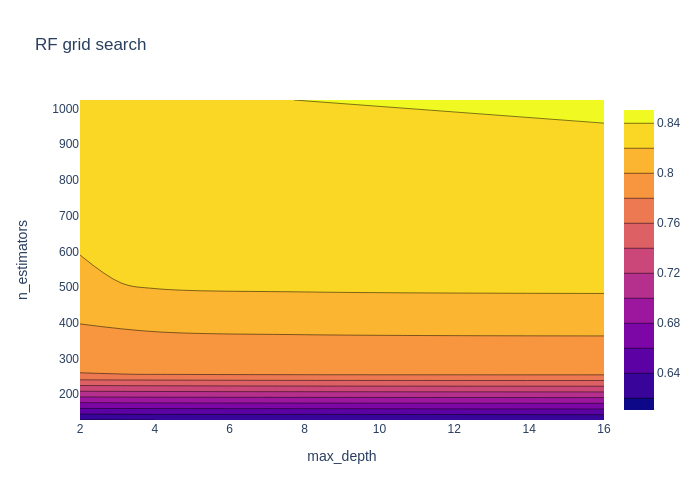

In [8]:
df = pd.DataFrame(grid)
z = df.query('split=="valid"')[criteria].values.reshape(len(max_depth_opts), len(n_estimators_opts))

fig = go.Figure(data =
    go.Contour(
        z=z,
        x=max_depth_opts, # horizontal axis
        y=n_estimators_opts # vertical axis
    ))
fig.update_layout(
    title="RF grid search",
    xaxis_title="max_depth",
    yaxis_title="n_estimators"
)
fig.show()

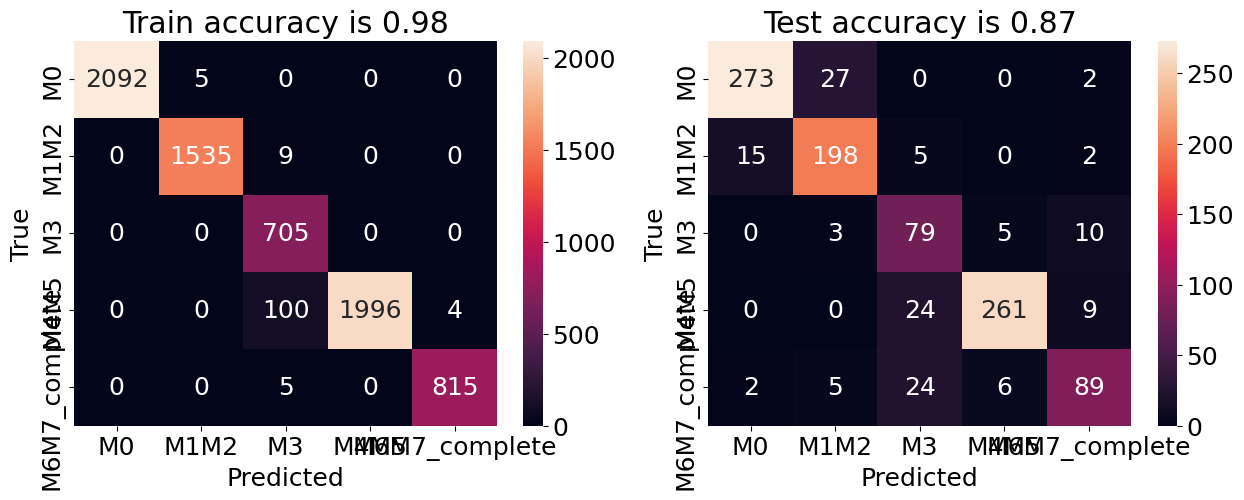

In [9]:
df_val = df.query('split=="valid"').sort_values(by=criteria, ascending=False)
best_clf_conf = list(df_val[['max_depth', 'n_estimators']].iloc[0].values)
best_clf = models[tuple(best_clf_conf)]

# Apply the model (to the training dataset)
y_trainpred = best_clf.predict(X_train)
# Apply the model (to the test dataset)
y_testpred = best_clf.predict(X_test)

# Show performance as a confusion matrix
cm_train = confusion_matrix(y_train, y_trainpred, labels = df_mitocells['cell_stage'].unique())                        
cm_test = confusion_matrix(y_test, y_testpred, labels = df_mitocells['cell_stage'].unique())                        

# plot it
labels = df_mitocells['cell_stage'].unique()
cm_train_df = pd.DataFrame(cm_train)
cm_test_df = pd.DataFrame(cm_test)
score_test = accuracy_score(y_test,y_testpred) #compute accuracy score
score_train = accuracy_score(y_train,y_trainpred) #compute accuracy score
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=100)
#train
sns.heatmap(cm_train_df, annot=True, fmt='d',ax=axes[0])
axes[0].set_title(f'Train accuracy is {score_train:.2f}')
axes[0].set_ylabel('True')
axes[0].set_xlabel('Predicted')
axes[0].set_xticklabels([''] + labels)
axes[0].set_yticklabels([''] + labels)
#test
sns.heatmap(cm_test_df, annot=True, fmt='d',ax=axes[1])
axes[1].set_title(f'Test accuracy is {score_test:.2f}')
axes[1].set_ylabel('True')
axes[1].set_xlabel('Predicted')
axes[1].set_xticklabels([''] + labels)
axes[1].set_yticklabels([''] + labels)
plt.show()

In [10]:
print(classification_report(y_test, y_testpred))

               precision    recall  f1-score   support

           M0       0.94      0.90      0.92       302
         M1M2       0.85      0.90      0.87       220
           M3       0.60      0.81      0.69        97
         M4M5       0.96      0.89      0.92       294
M6M7_complete       0.79      0.71      0.75       126

     accuracy                           0.87      1039
    macro avg       0.83      0.84      0.83      1039
 weighted avg       0.88      0.87      0.87      1039



In [11]:
# "M0" - interphase
# "M1/M2" - prophase
# "M3" - early prometaphase
# "M4/M5" - prometaphase/metaphase
# "M6/M7" - anaphase/telophase/cytokinesis

# SVC Baseline

In [ ]:
from sklearn.svm import SVC
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

C_opts = np.logspace(-2, 3, 6)
gamma_opts = np.logspace(-9, 3, 13)
grid = []
models = {}
for gamma in tqdm(gamma_opts):
    for C in tqdm(C_opts, leave=False):
        clf = Pipeline([('scaler', StandardScaler()), ('svc', SVC(gamma=gamma, C=C))])
        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_train)
        scores = classification_report(y_train, y_pred, output_dict=True, zero_division=0)[agg_metric]
        scores['gamma'] = gamma
        scores['C'] = C
        scores['split'] = 'train'
        grid.append(scores)
        
        y_pred = clf.predict(X_val)
        scores = classification_report(y_val, y_pred, output_dict=True, zero_division=0)[agg_metric]
        scores['gamma'] = gamma
        scores['C'] = C
        scores['split'] = 'valid'
        grid.append(scores)
        
        models[(gamma, C)] = clf

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame(grid)
z = df.query('split=="valid"')[criteria].values.reshape(len(gamma_opts), len(C_opts))

fig = go.Figure(data=
    go.Contour(
        z=z,
        x=gamma_opts, # horizontal axis
        y=C_opts # vertical axis
    ))
fig.update_layout(
    title="SVM-RBF grid search",
    xaxis_title="gamma",
    yaxis_title="C"
)
fig.update_xaxes(type="log")
fig.update_yaxes(type="log")

fig.show()

In [ ]:
df_val = df.query('split=="valid"').sort_values(by=criteria, ascending=False)
best_clf_conf = list(df_val[['gamma', 'C']].iloc[0].values)
best_clf = models[tuple(best_clf_conf)]

# Apply the model (to the training dataset)
y_trainpred = best_clf.predict(X_train)
# Apply the model (to the test dataset)
y_testpred = best_clf.predict(X_test)

# Show performance as a confusion matrix
cm_train = confusion_matrix(y_train, y_trainpred, labels = df_mitocells['cell_stage'].unique())                        
cm_test = confusion_matrix(y_test, y_testpred, labels = df_mitocells['cell_stage'].unique())                        

# plot it
labels = df_mitocells['cell_stage'].unique()
cm_train_df = pd.DataFrame(cm_train)
cm_test_df = pd.DataFrame(cm_test)
score_test = accuracy_score(y_test,y_testpred) #compute accuracy score
score_train = accuracy_score(y_train,y_trainpred) #compute accuracy score
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=100)
#train
sns.heatmap(cm_train_df, annot=True, fmt='d',ax=axes[0])
axes[0].set_title(f'Train accuracy is {score_train:.2f}')
axes[0].set_ylabel('True')
axes[0].set_xlabel('Predicted')
axes[0].set_xticklabels([''] + labels)
axes[0].set_yticklabels([''] + labels)
#test
sns.heatmap(cm_test_df, annot=True, fmt='d',ax=axes[1])
axes[1].set_title(f'Test accuracy is {score_test:.2f}')
axes[1].set_ylabel('True')
axes[1].set_xlabel('Predicted')
axes[1].set_xticklabels([''] + labels)
axes[1].set_yticklabels([''] + labels)
plt.show()

In [ ]:
print(classification_report(y_test, y_testpred))